In [1]:
!pip install fastai --upgrade
!pip install timm wwf

     |████████████████████████████████| 194kB 9.2MB/s 
     |████████████████████████████████| 61kB 7.7MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61
     |████████████████████████████████| 245kB 8.0MB/s 


In [2]:
!wget https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1 -O erm.zip

--2021-03-01 16:14:10--  https://www.dropbox.com/s/cb3g53z4pbtaqvl/erm.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.1.18, 2620:100:601a:18::a27d:712
Connecting to www.dropbox.com (www.dropbox.com)|162.125.1.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/dl/cb3g53z4pbtaqvl/erm.zip [following]
--2021-03-01 16:14:10--  https://www.dropbox.com/s/dl/cb3g53z4pbtaqvl/erm.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc28e833abec9caa0f6fbfe37666.dl.dropboxusercontent.com/cd/0/get/BJ1sNFeP-6geq1PBVmVaQG7bmg6-El-ehZuvpFcuxlrtevlDMgMSCtdXeBKSbwE9pFaWNFTzDPvULtJGTnoCtx-qJD8UXJcdhtxvc7C8stZhiW03iexR6q95r1raJATR4qY/file?dl=1# [following]
--2021-03-01 16:14:10--  https://uc28e833abec9caa0f6fbfe37666.dl.dropboxusercontent.com/cd/0/get/BJ1sNFeP-6geq1PBVmVaQG7bmg6-El-ehZuvpFcuxlrtevlDMgMSCtdXeBKSbwE9pFaWNFTzDPvULtJGTnoCtx-qJD8UXJcdhtxvc7C8stZhiW03iexR6q95r1ra

In [3]:
!unzip erm.zip

Archive:  erm.zip
   creating: dataset/
   creating: dataset/test/
   creating: dataset/test/no/
  inflating: dataset/test/no/anonymized_1421704.jpg  
  inflating: dataset/test/no/anonymized_336537.jpg  
  inflating: dataset/test/no/anonymized_569526.jpg  
  inflating: dataset/test/no/anonymized_196860.jpg  
  inflating: dataset/test/no/anonymized_920184.jpg  
  inflating: dataset/test/no/anonymized_1348815.jpg  
  inflating: dataset/test/no/anonymized_225304.jpg  
  inflating: dataset/test/no/anonymized_816099.jpg  
  inflating: dataset/test/no/anonymized_260226.jpg  
  inflating: dataset/test/no/anonymized_1619231.jpg  
  inflating: dataset/test/no/anonymized_1314755.jpg  
  inflating: dataset/test/no/anonymized_1182585.jpg  
  inflating: dataset/test/no/anonymized_656024.jpg  
  inflating: dataset/test/no/anonymized_198917.jpg  
  inflating: dataset/test/no/anonymized_246204.jpg  
  inflating: dataset/test/no/anonymized_324557.jpg  
  inflating: dataset/test/no/anonymized_492637.jpg

In [4]:
from fastai.vision.all import *
import fastai
from wwf.vision.timm import *

In [5]:
path = Path('dataset/')
trainPath = path/'train'
testPath = path/'test'

In [6]:
def getDataBlock(presize=512,size=256):
    return DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=RandomSplitter(valid_pct=0.2,seed=42),
                 get_y=parent_label,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])

In [7]:
db512 = getDataBlock()
dls512 = db512.dataloaders(trainPath,bs=64)

In [8]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='hrnet_w32'),
]

In [9]:
import timm
timm.list_models('*hrnet_w32*')

['hrnet_w32']

In [10]:
learn = Learner(dls512, timm.models.hrnet.hrnet_w32(num_classes=2),cbs = callbacks,metrics=[accuracy,Precision(),Recall()]).to_fp16()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-hrnet/hrnetv2_w32-90d8c5fb.pth" to /root/.cache/torch/hub/checkpoints/hrnetv2_w32-90d8c5fb.pth


SuggestedLRs(lr_min=0.13182567358016967, lr_steep=1.0964782238006592)

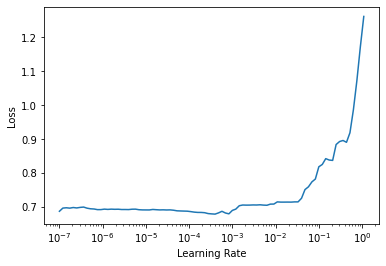

In [11]:
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.690469,0.677918,0.570336,0.542334,0.745283,01:02


Better model found at epoch 0 with valid_loss value: 0.6779184341430664.


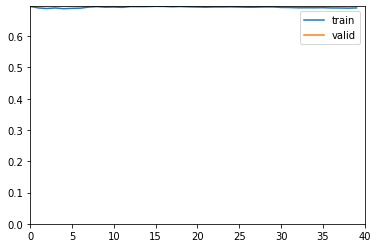

epoch,train_loss,valid_loss,accuracy,precision_score,recall_score,time
0,0.671066,0.673154,0.579511,0.552311,0.713836,01:01
1,0.670224,0.669587,0.587156,0.556872,0.738994,01:01
2,0.665883,0.661045,0.596330,0.569588,0.694969,01:01
3,0.654946,0.646629,0.652905,0.642633,0.644654,01:01
4,0.641673,0.629633,0.654434,0.634503,0.682390,01:01
5,0.620064,0.611554,0.671254,0.635171,0.761006,01:01
6,0.594813,0.586857,0.678899,0.666667,0.679245,01:01
7,0.565999,0.565931,0.697248,0.688679,0.688679,01:01
8,0.533127,0.552476,0.711009,0.703470,0.701258,01:01
9,0.507634,0.544864,0.715596,0.711538,0.698113,01:01


Better model found at epoch 0 with valid_loss value: 0.6731540560722351.


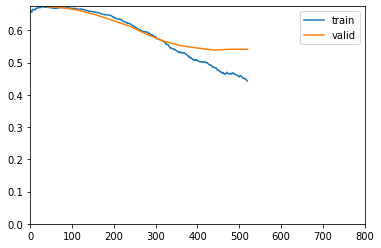

Better model found at epoch 1 with valid_loss value: 0.6695867776870728.
Better model found at epoch 2 with valid_loss value: 0.661044716835022.
Better model found at epoch 3 with valid_loss value: 0.6466286778450012.
Better model found at epoch 4 with valid_loss value: 0.6296331882476807.
Better model found at epoch 5 with valid_loss value: 0.6115544438362122.
Better model found at epoch 6 with valid_loss value: 0.5868571400642395.
Better model found at epoch 7 with valid_loss value: 0.5659312605857849.
Better model found at epoch 8 with valid_loss value: 0.5524760484695435.
Better model found at epoch 9 with valid_loss value: 0.544863760471344.
Better model found at epoch 10 with valid_loss value: 0.53862464427948.
No improvement since epoch 10: early stopping


In [12]:
learn.fine_tune(20,base_lr=1e-5)

In [13]:
dbTest = DataBlock(blocks = (ImageBlock, CategoryBlock),
                 get_items=get_image_files, 
                 splitter=GrandparentSplitter(valid_name='test'),
                 get_y=parent_label,
                 item_tfms = Resize(512),
                 batch_tfms=[*aug_transforms(size=256, min_scale=0.75), Normalize.from_stats(*imagenet_stats)])
dlsTest = dbTest.dataloaders(path,bs=32)

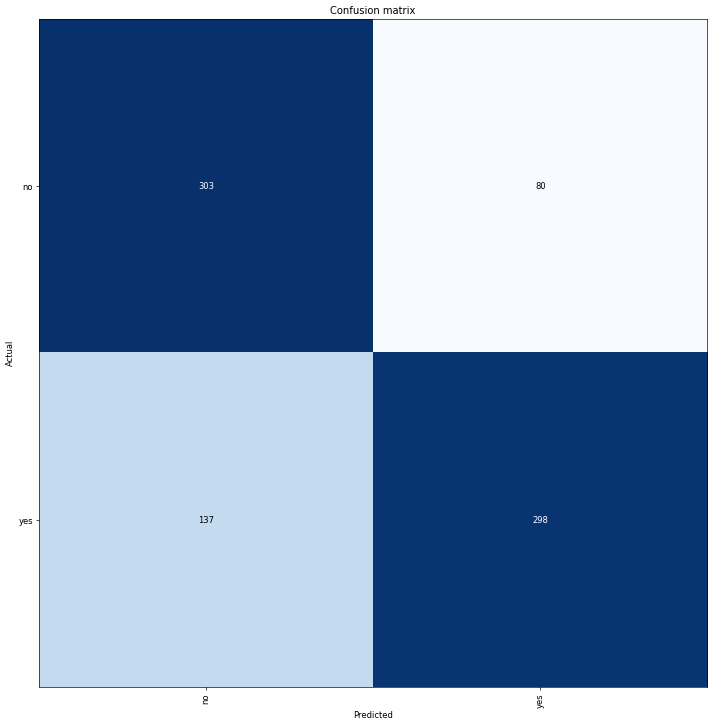

In [14]:
learn.dls = dlsTest
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12),dpi=60)

In [15]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 0.7347187995910645.


(#4) [0.5697019696235657,0.7347187995910645,0.7883597883597884,0.6850574712643678]

In [16]:
learn.export(fname='hrnet.pkl')